In [1]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

if code_dir_name not in str(Path.cwd()).split('/')[-1]:
    for _ in range(5):

        parent_path = str(Path.cwd().parents[_]).split('/')[-1]

        if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

            code_dir = str(Path.cwd().parents[_])

            if code_dir is not None:
                break
else:
    code_dir = str(Path.cwd())
sys.path.append(code_dir)

# %load_ext autoreload
# %autoreload 2


In [2]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from setup_module.estimators_get_pipe import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from setup_module.plot_metric_fork import functions as plot_metric_functions # type:ignore # isort:skip # fmt:skip # noqa # nopep8


Using MPS


0it [00:00, ?it/s]

Using MPS


<Figure size 640x480 with 0 Axes>

### Set variables

In [3]:
# Variables
method = 'Supervised'
with open(f'{data_dir}{method}_results_save_path.txt', 'r') as f:
    results_save_path = f.read().strip('\n')
with open(f'{data_dir}{method}_done_xy_save_path.txt', 'r') as f:
    done_xy_save_path = f.read().strip('\n')

t = time.time()
n_jobs = -1
n_splits = 10
n_repeats = 3
random_state = 42
refit = True
class_weight = 'balanced'
cv = RepeatedStratifiedKFold(
    n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
)
scoring = 'recall'
scores = [
    'recall', 'accuracy', 'f1', 'roc_auc',
    'explained_variance', 'matthews_corrcoef'
]
scorers = {
    'precision_score': make_scorer(precision_score, zero_division=0),
    'recall_score': make_scorer(recall_score, zero_division=0),
    'accuracy_score': make_scorer(accuracy_score, zero_division=0),
}
analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'
metrics_dict = {
    f'{scoring.title()} Best Score': np.nan,
    f'{scoring.title()} Best Threshold': np.nan,
    'Train - Mean Cross Validation Score': np.nan,
    f'Train - Mean Cross Validation - {scoring.title()}': np.nan,
    f'Train - Mean Explained Variance - {scoring.title()}': np.nan,
    'Test - Mean Cross Validation Score': np.nan,
    f'Test - Mean Cross Validation - {scoring.title()}': np.nan,
    f'Test - Mean Explained Variance - {scoring.title()}': np.nan,
    'Explained Variance': np.nan,
    'Accuracy': np.nan,
    'Balanced Accuracy': np.nan,
    'Precision': np.nan,
    'Average Precision': np.nan,
    'Recall': np.nan,
    'F1-score': np.nan,
    'Matthews Correlation Coefficient': np.nan,
    'Brier Score': np.nan,
    'Fowlkes–Mallows Index': np.nan,
    'R2 Score': np.nan,
    'ROC': np.nan,
    'AUC': np.nan,
    'Log Loss/Cross Entropy': np.nan,
    'Cohen’s Kappa': np.nan,
    'Geometric Mean': np.nan,
    'Classification Report': np.nan,
    'Imbalanced Classification Report': np.nan,
    'Confusion Matrix': np.nan,
    'Normalized Confusion Matrix': np.nan,
}
skip_fitted_estimators = False
evaluate_estimator_on_concat = False


# Functions

In [4]:
def show_and_close_plots():
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()


In [5]:
def close_plots():
    plt.clf()
    plt.cla()
    plt.close()


In [6]:
def make_df_metrics(
    vectorizers_pipe, classifiers_pipe, transformers_pipe, metrics_list,
    col, vectorizer_name, classifier_name, protocol=None,
    analysis_columns=analysis_columns,
    table_save_path=table_save_path,
    method=method, save_name=None,
    compression=None, path_suffix=None,
):
    if save_name is None:
        save_name = f'{method} Estimators Table'
    if compression is None:
        compression = False
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if isinstance(metrics_list, dict):
        metrics_list = list(metrics_list.keys())

    transformers_tokenizers_list = [
        str(tranformer_dict['tokenizer']).split('.')[-1].split("'>")[0]
        for tranformer_dict in transformers_pipe.values()
    ]
    combined_classifiers_list = list(classifiers_pipe.keys()) + list(transformers_pipe.keys())
    combined_vectorizers_list = list(vectorizers_pipe.keys()) + transformers_tokenizers_list

    print('='*20)
    if os.path.exists(f'{table_save_path}{save_name}.pkl') and os.path.getsize(f'{table_save_path}{save_name}.pkl') > 0:
        print(f'Loading table from {table_save_path}{save_name}.pkl')
        df_metrics = pd.read_pickle(f'{table_save_path}{save_name}.pkl')
        print('Done loading table!')
    else:
        print('Table does not exist, creating new table...')
        if method == 'Transformers':
            index = pd.MultiIndex.from_product(
                [list(map(lambda classifier_name: classifier_name, list(transformers_pipe.keys())))],
                names=['Classifiers'],
            )
            columns = pd.MultiIndex.from_product(
                [
                    analysis_columns,
                    metrics_list,
                ],
                names=['Variable', 'Measures'],
            )
        elif method == 'Supervised':
            index = pd.MultiIndex.from_product(
                [list(map(lambda classifier_name: classifier_name, list(classifiers_pipe.keys())))],
                names=['Classifiers'],
            )
            columns = pd.MultiIndex.from_product(
                [
                    analysis_columns,
                    list(map(lambda vectorizer_name: vectorizer_name, list(vectorizers_pipe.keys()))),
                    metrics_list,
                ],
                names=['Variable', 'Vectorizer', 'Measures'],
            )
        # Make df
        df_metrics = pd.DataFrame(index=index, columns=columns)
        print('Done creating new table!')
    print('='*20)

    return df_metrics


In [7]:
def get_existing_files(
    results_save_path=results_save_path,
    estimator_names_list=None,
):
    if estimator_names_list is None:
        estimator_names_list = []

    print(f'Searching for existing estimators in directory:\n{results_save_path}')

    for estimators_file in tqdm.tqdm(glob.glob(f'{results_save_path}*.*')):
        if f'{method} Estimator - ' in estimators_file:

            col=estimators_file.split(f'{method} Estimator - ')[-1].split(' - ')[0]
            vectorizer_name=estimators_file.split(f'{col} - ')[-1].split(' + ')[0]
            classifier_name=estimators_file.split(f'{vectorizer_name} + ')[-1].split(' (Save_protocol=')[0]

            estimator_names_list.append(f'{col} - {vectorizer_name} + {classifier_name}')

    return (
        list(set(estimator_names_list))
    )


In [8]:
def load_Xy_search_cv_estimator(
    col, vectorizer_name, classifier_name, protocol,
    results_save_path=results_save_path,
    done_xy_save_path=done_xy_save_path, method=method,
    compression=None, saved_files_list=None,
    path_suffix=None, data_dict=None,
):
    if compression is None:
        compression = False
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if path_suffix is None:
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'
    if data_dict is None:
        data_dict = {}
    if saved_files_list is None:
        saved_files_list = []

    # Load data into dict
    for file_path in glob.glob(f'{done_xy_save_path}{method}*{path_suffix}*'):
        file_name = file_path.split(f'{done_xy_save_path}{method} ')[-1].split(path_suffix)[0]
        print(f'Loading {file_name} from {file_path}')
        if 'df_' in file_name:
            data_dict[file_name] = pd.read_pickle(file_path)
        else:
            with open(file_path, 'rb') as f:
                data_dict[file_name] = joblib.load(f)
        saved_files_list.append(file_name)
    # Load estimator
    print('Loading Estimator.')
    with open(
        f'{results_save_path}{method} Estimator{path_suffix}', 'rb'
    ) as f:
        data_dict['Estimator'] = joblib.load(f)
    saved_files_list.append('Estimator')

    # # Assign data to variables
    estimator = data_dict['Estimator']
    grid_search = data_dict['Grid Search']
    searchcv = data_dict['SearchCV']
    df_cv_results = data_dict['df_cv_results']
    # Train data
    df_train_data = data_dict['df_train_data']
    X_train = df_train_data['X_train'].values
    y_train = df_train_data['y_train'].values
    y_train_pred = df_train_data['y_train_pred'].values
    # Test data
    df_test_data = data_dict['df_test_data']
    X_test = df_test_data['X_test'].values
    y_test = df_test_data['y_test'].values
    y_test_pred = df_test_data['y_test_pred'].values
    y_test_pred_prob = df_test_data['y_test_pred_prob'].values
    # Val data
    df_val_data = data_dict['df_val_data']
    X_val = df_val_data['X_val'].values
    y_val = df_val_data['y_val'].values
    y_val_pred = df_val_data['y_val_pred'].values
    y_val_pred_prob = df_val_data['y_val_pred_prob'].values
    # Feature importances
    if 'df_feature_importances' in data_dict.keys():
        saved_files_list.append('df_feature_importances')
        df_feature_importances = data_dict['df_feature_importances']
    else:
        df_feature_importances = None

    # Check data
    check_consistent_length(X_train, y_train, y_train_pred)
    check_consistent_length(X_test, y_test, y_test_pred, y_test_pred_prob)
    check_is_fitted(estimator)

    # Get class weights
    (
        train_class_weights, train_class_weights_ratio, train_class_weights_dict,
        test_class_weights, test_class_weights_ratio, test_class_weights_dict,
        val_class_weights, val_class_weights_ratio, val_class_weights_dict,
    ) = get_class_weights(
        X_train, y_train,
        X_test, y_test,
        X_val, y_val,
    )
    # Print info
    print_Xy(
        X_train, y_train,
        X_test, y_test,
        X_val, y_val,
        train_class_weights, train_class_weights_ratio, train_class_weights_dict,
        test_class_weights, test_class_weights_ratio, test_class_weights_dict,
        val_class_weights, val_class_weights_ratio, val_class_weights_dict,
    )

    assert set(data_dict.keys()) == set(saved_files_list), f'Not all files were loaded! Missing: {set(data_dict.keys()) ^ set(saved_files_list)}'
    print(f'Done loading Xy, CV data, and estimator!\n{list(data_dict.keys())}')
    print('='*20)

    return (
        grid_search, searchcv,
        X_train, y_train, y_train_pred,
        X_test, y_test, y_test_pred, y_test_pred_prob,
        X_val, y_val, y_val_pred, y_val_pred_prob,
        df_feature_importances, df_cv_results, estimator,
    )


In [9]:
def get_class_weights(
    X_train, y_train,
    X_test, y_test,
    X_val, y_val,
):
    # Get train class weights
    train_class_weights = compute_class_weight(class_weight = class_weight, classes = np.unique(y_train), y = y_train)
    train_class_weights_ratio = train_class_weights[0]/train_class_weights[1]
    train_class_weights_dict = dict(zip(np.unique(y_train), train_class_weights))

    # Get train class weights
    test_class_weights = compute_class_weight(class_weight = class_weight, classes = np.unique(y_train), y = y_test)
    test_class_weights_ratio = test_class_weights[0]/test_class_weights[1]
    test_class_weights_dict = dict(zip(np.unique(y_test), test_class_weights))

    # Get val class weights
    val_class_weights = compute_class_weight(class_weight = class_weight, classes = np.unique(y_train), y = y_val)
    val_class_weights_ratio = val_class_weights[0]/val_class_weights[1]
    val_class_weights_dict = dict(zip(np.unique(y_val), val_class_weights))

    return (
        train_class_weights, train_class_weights_ratio, train_class_weights_dict,
        test_class_weights, test_class_weights_ratio, test_class_weights_dict,
        val_class_weights, val_class_weights_ratio, val_class_weights_dict,
    )


In [10]:
def print_Xy(
    X_train, y_train,
    X_test, y_test,
    X_val, y_val,
    train_class_weights, train_class_weights_ratio, train_class_weights_dict,
    test_class_weights, test_class_weights_ratio, test_class_weights_dict,
    val_class_weights, val_class_weights_ratio, val_class_weights_dict,
):
    # Check for consistent length
    check_consistent_length(X_train, y_train)
    check_consistent_length(X_test, y_test)
    check_consistent_length(X_val, y_val)

    print('Done splitting data into training and testing sets.')
    print('='*20)
    print(f'Training set shape: {y_train.shape}')
    print('-'*10)
    print(f'Training set example:\n{X_train[0]}')
    print('~'*10)
    print(f'Testing set shape: {y_test.shape}')
    print('-'*10)
    print(f'Testing set example:\n{X_test[0]}')
    print('~'*10)
    print(f'Validation set shape: {y_val.shape}')
    print('-'*10)
    print(f'Validation set example:\n{X_val[0]}')
    print('~'*10)
    print(f'Training data class weights:\nRatio = {train_class_weights_ratio:.2f} (0 = {train_class_weights[0]:.2f}, 1 = {train_class_weights[1]:.2f})')
    print('-'*10)
    print(f'Testing data class weights:\nRatio = {test_class_weights_ratio:.2f} (0 = {test_class_weights[0]:.2f}, 1 = {test_class_weights[1]:.2f})')
    print('-'*10)
    print(f'Validation data class weights:\nRatio = {val_class_weights_ratio:.2f} (0 = {val_class_weights[0]:.2f}, 1 = {val_class_weights[1]:.2f})')
    print('='*20)


In [11]:
def compute_metrics_with_estimator(
    estimator, X, y_labels, col, vectorizer_name, classifier_name,
    cv=cv, return_train_score=None, results_save_path=results_save_path, print_enabled=None
):
    if return_train_score is None:
        return_train_score = True
    if print_enabled is None:
        print_enabled = True

    # Using estimator
    # Cross Validation
    if print_enabled:
        print('-'*20)
        print('Computing metrics using estimator.')
        print('-'*20)
        print('Cross Validating without scoring.')
    cv_score_noscoring = cross_validate(
        estimator,
        X,
        y_labels,
        cv=cv,
        scoring=None,
        return_train_score=return_train_score,
    )

    # Cross Validation with scoring
    if print_enabled:
        print('-'*20)
        print(f'Cross Validating with {scores} scoring.')
    cv_score_recall = cross_validate(
        estimator,
        X,
        y_labels,
        cv=cv,
        scoring=scores,
        return_train_score=return_train_score,
    )

    # Get mean and std of cross validation scores
    if print_enabled:
        print('-'*20)
        print('Getting mean and std of cross validation scores.')
    cv_train_scores = cv_score_noscoring['train_score'].mean()
    cv_test_scores = cv_score_noscoring['test_score'].mean()
    cv_train_recall = cv_score_recall['train_recall'].mean()
    cv_test_recall = cv_score_recall['test_recall'].mean()
    cv_train_explained_variance_recall = cv_score_recall['train_explained_variance'].mean()
    cv_test_explained_variance_recall = cv_score_recall['test_explained_variance'].mean()

    # Save cross validation scores to dataframe
    if print_enabled:
        print('-'*20)
        print('Saving cross validation scores to dataframe.')
    df_cv_score_noscoring = pd.DataFrame(cv_score_noscoring)
    df_cv_score_noscoring.to_pickle(f'{results_save_path}df_cv_score_noscoring - {col}_{vectorizer_name}_{classifier_name}.pkl')
    df_cv_score_recall = pd.DataFrame(cv_score_recall)
    df_cv_score_recall.to_pickle(f'{results_save_path}df_cv_score_recall - {col}_{vectorizer_name}_{classifier_name}.pkl')

    return (
        df_cv_score_recall,
        cv_train_scores, cv_test_scores,
        cv_train_recall, cv_test_recall,
        cv_train_explained_variance_recall, cv_test_explained_variance_recall
    )


In [12]:
def plot_metrics_with_estimator(
    estimator, X_test, y_test, col, vectorizer_name, classifier_name, random_state=random_state, n_jobs=n_jobs, cv=cv,
    params=None, axis=None, alpha=None, verbose=None
):
    if axis is None:
        axis = 1
    if alpha is None:
        alpha = 0.1
    if verbose is None:
        verbose=1

    # Make param names and values
    if params is None:
        params = {
            param_name: classifier_params
            for classifier_name, classifier_and_params in classifiers_pipe.items()
            if estimator[-1].__class__.__name__ == classifier_name
            for param_name_, classifier_params in classifier_and_params[-1].items()
            for param_name in [param_name_.split(f'{classifier_name}__')[-1]]
            if param_name != 'random_state' and all(isinstance(n, (list, int, float)) for n in classifier_params) and not all(isinstance(n, (bool)) for n in classifier_params)
        }


    # Learning Curves
    print('Plotting Learning Curve.')
    print('-'*20)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=estimator,
        X=X_train,
        y=y_train,
        cv=cv,
        n_jobs=n_jobs,
        random_state=random_state,
        shuffle=True,
        scoring=scoring,
        verbose=verbose,
        # train_sizes=np.linspace(0.1, 1.0, 10),
    )
    train_scores_mean = np.mean(train_scores, axis=axis)
    train_scores_std = np.std(train_scores, axis=axis)
    test_scores_mean = np.mean(test_scores, axis=axis)
    test_scores_std = np.std(test_scores, axis=axis)

    close_plots()
    plt.figure()
    plt.title(
        f'{col} - Learning Curves for {scoring.title()} - {vectorizer_name} + {classifier_name}'
        )
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.grid()
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=alpha, color='r'
    )
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=alpha, color='g'
    )
    plt.plot(
        train_sizes, train_scores_mean, 'o-', color='r', label='Training score'
    )
    plt.plot(
        train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score'
    )
    plt.legend(loc='best')
    fig = plt.gcf()
    fig.tight_layout()

    # Save figure
    for image_save_format in ['eps', 'png', 'svg']:
        save_path = f'{plot_save_path}{method} {col} - Learning Curve - {vectorizer_name} + {classifier_name}.{image_save_format}'
        print(f'Saving Learning Curve at {save_path}.')
        fig.savefig(save_path, format=image_save_format)
    show_and_close_plots()

    # Validation Curve
    for param_name, param_range in params.items():
        param_title = ' '.join(param_name.split('_')).title()
        print(f'Plotting Validation Curve for {param_title}.')
        print('-'*20)
        train_scores, test_scores = validation_curve(
            estimator=estimator[-1],
            X=X_train,
            y=y_train,
            param_name=param_name,
            param_range=param_range,
            cv=cv,
            n_jobs=n_jobs,
            scoring=scorers['recall_score'],
            verbose=1,
        )
        train_scores_mean = np.mean(train_scores, axis=axis)
        train_scores_std = np.std(train_scores, axis=axis)
        test_scores_mean = np.mean(test_scores, axis=axis)
        test_scores_std = np.std(test_scores, axis=axis)

        # Ploting
        plt.figure()
        plt.title(
            f'{col} - Validation Curve for {scoring.title()} - {col} - {vectorizer_name} + {classifier_name}'
        )
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.grid()
        plt.fill_between(
            param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=alpha, color='r'
        )
        plt.fill_between(
            param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=alpha, color='g'
        )
        plt.semilogx(
            param_range, train_scores_mean, label='Training score', color='r'
        )
        plt.semilogx(
            param_range, test_scores_mean, label='Cross-validation score', color='g'
        )
        plt.plot(
            param_range, train_scores_mean, 'o-', color='r', label='Training score'
        )
        plt.plot(
            param_range, test_scores_mean, 'o-', color='g', label='Cross-validation score'
        )
        plt.legend(loc='best')
        fig = plt.gcf()
        fig.tight_layout()

        # Save figure
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} {col} - Validation Curve for {scoring.title()} - {vectorizer_name} + {classifier_name}.{image_save_format}'
            print(f'Saving Validation Curve at {save_path}')
            fig.savefig(
                save_path, format=image_save_format
            )
        show_and_close_plots()


In [13]:
def compute_metrics_with_y_pred(
    y_labels, y_pred,
    pos_label=None, labels=None, zero_division=None, alpha=None, print_enabled=None
):
    if pos_label is None:
        pos_label = 1
    if labels is None:
        labels = np.unique(y_pred)
    if zero_division is None:
        zero_division = 0
    if alpha is None:
        alpha = 0.1
    if print_enabled is None:
        print_enabled = True

    if print_enabled:
        print('-'*20)
        print('Computing metrics using y_pred.')
    # Using y_pred
    explained_variance = metrics.explained_variance_score(y_labels, y_pred)
    accuracy = metrics.accuracy_score(y_labels, y_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_labels, y_pred)
    precision = metrics.precision_score(y_labels, y_pred, pos_label=pos_label, labels=labels, zero_division=zero_division)
    recall = metrics.recall_score(y_labels, y_pred, pos_label=pos_label, labels=labels, zero_division=zero_division)
    f1 = metrics.f1_score(y_labels, y_pred, pos_label=pos_label,labels=labels, zero_division=zero_division)
    mcc = metrics.matthews_corrcoef(y_labels, y_pred)
    brier = metrics.brier_score_loss(y_labels, y_pred)
    fm = metrics.fowlkes_mallows_score(y_labels, y_pred)
    r2 = metrics.r2_score(y_labels, y_pred)
    kappa = metrics.cohen_kappa_score(y_labels, y_pred, labels=labels)
    gmean_iba = imblearn.metrics.make_index_balanced_accuracy(alpha=alpha, squared=True)(geometric_mean_score)
    gmean = gmean_iba(y_labels, y_pred)
    report = metrics.classification_report(y_labels, y_pred, labels=labels, zero_division=zero_division)
    imblearn_report = classification_report_imbalanced(y_labels, y_pred, labels=labels, zero_division=zero_division)
    cm = metrics.confusion_matrix(y_labels, y_pred, labels=labels)
    cm_normalized = metrics.confusion_matrix(y_labels, y_pred, normalize='true', labels=labels)

    return (
        explained_variance, accuracy, balanced_accuracy, precision,
        recall, f1, mcc, brier, fm, r2, kappa, gmean, report, imblearn_report, cm, cm_normalized
    )


In [14]:
def plot_metrics_with_y_pred(
    y_labels, y_pred, col, vectorizer_name, classifier_name,
    pos_label=None, labels=None
):
    if pos_label is None:
        pos_label = 1
    if labels is None:
        labels = np.unique(y_pred)

    # Displays
    close_plots()
    cm_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_labels, y_pred, display_labels=labels, cmap=plt.cm.Blues, colorbar=True
    )
    cm_normalized_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_labels, y_pred, normalize='true', display_labels=labels, cmap=plt.cm.Blues, colorbar=True
    )
    roc_curve = metrics.RocCurveDisplay.from_predictions(
        y_labels, y_pred, pos_label=pos_label, color='C0'
    )
    pr_curve = metrics.PrecisionRecallDisplay.from_predictions(
        y_labels, y_pred, pos_label=pos_label, color='C0'
    )
    calibration_curve = CalibrationDisplay.from_predictions(
        y_labels, y_pred, pos_label=pos_label, color='C0'
    )
    show_and_close_plots()

    # Plots
    plots_dict = {
        'Confusion Matrix': cm_curve,
        'Normalized Confusion Matrix': cm_normalized_curve,
        'ROC Curve': roc_curve,
        'Precision-Recall Curve': pr_curve,
        'Calibration Curve': calibration_curve,
    }

    print('=' * 20)
    close_plots()
    print('Plotting metrics with y_pred:')
    print('='*20)

    for plot_name, plot_ in plots_dict.items():
        close_plots()
        print(f'Plotting {plot_name}:')
        fig, ax = plt.subplots()
        ax.set_title(
            f'{col} - {plot_name} - {vectorizer_name} + {classifier_name}'
            )
        if plot_name == 'ROC Curve':
            ax.plot([0, 1], [0, 1], 'r--', lw=1)
        try:
            plot_.plot(ax=ax, cmap=plt.cm.Blues)
        except Exception:
            plot_.plot(ax=ax, color='C0')
        print('=' * 20)
        fig = plt.gcf()
        fig.tight_layout()

        # Save Plots
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} {col} - {plot_name} - {vectorizer_name} + {classifier_name}.{image_save_format}'
            print(f'Saving {plot_name} at {save_path}')
            try:
                fig.savefig(
                    save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
                )
            except Exception:
                print(f'Failed to save {plot_name}!')
                print('=' * 20)
            else:
                print(f'Saved {plot_name}!')
                print('=' * 20)
        show_and_close_plots()

    # with contextlib.suppress(AttributeError):
    # Visualisation with plot_metric
    bc = plot_metric_functions.BinaryClassification(y_labels, y_pred, labels=[0, 1], matplotlib_style='tableau-colorblind10', seaborn_style='whitegrid')

    # Figures
    close_plots()
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f'{col} - {vectorizer_name} + {classifier_name}')
    plt.subplot2grid((2, 6), (1, 1), colspan=2)
    bc.plot_confusion_matrix(colorbar=True, cmap=plt.cm.Blues)
    plt.subplot2grid((2, 6), (1, 3), colspan=2)
    bc.plot_confusion_matrix(normalize=True, colorbar=True, cmap=plt.cm.Blues)
    plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=2)
    bc.plot_roc_curve()
    plt.subplot2grid((2, 6), (0, 2), colspan=2)
    bc.plot_precision_recall_curve()
    plt.subplot2grid((2, 6), (0, 4), colspan=2)
    bc.plot_class_distribution()
    bc.print_report()
    fig = plt.gcf()
    fig.tight_layout()

    # Save Plots
    for image_save_format in ['eps', 'png', 'svg']:
        save_path = f'{plot_save_path}{method} {col} - plot_metric Curves - {vectorizer_name} + {classifier_name}.{image_save_format}'
        print(f'Saving plot_metric Curves at {save_path}')
        fig.savefig(
            save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
        )
    show_and_close_plots()

    # Heatmap
    print('Plotting Heatmap:')
    close_plots()
    classifications_dict = defaultdict(int)
    for _y_labels, _y_pred in zip(y_labels, y_pred):
        if _y_labels != _y_pred:
            classifications_dict[(_y_labels, _y_pred)] += 1

    dicts_to_plot = [
        {
            f'True {col} value': _y_labels,
            f'Predicted {col} value': _y_pred,
            'Number of Classifications': _count,
        }
        for (_y_labels, _y_pred), _count in classifications_dict.items()
    ]
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(
        index=f'True {col} value',
        columns=f'Predicted {col} value',
        values='Number of Classifications'
    )
    plt.figure(figsize=(9,7))
    sns.set(style='ticks', font_scale=1.2)
    sns.heatmap(df_wide, linewidths=1, cmap=plt.cm.Blues, annot=True)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title(f'{col} Heatmap - {vectorizer_name} + {classifier_name}')
    fig = plt.gcf()
    fig.tight_layout()

    # Save Heatmap
    for image_save_format in ['eps', 'png', 'svg']:
        save_path = f'{plot_save_path}{method} {col} - Heatmap - {vectorizer_name} + {classifier_name}.{image_save_format}'
        print(f'Saving Heatmap at {save_path}')
        fig.savefig(
            save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
        )
    print('Saved Heatmap!')
    show_and_close_plots()


In [15]:
def compute_metrics_with_y_pred_prob(
    y_labels, y_pred_prob,
    pos_label=None,
    print_enabled=None
):
    if pos_label is None:
        pos_label = 1
    if print_enabled is None:
        print_enabled = True

    if print_enabled:
        print('-'*20)
        print('Computing metrics using y_pred_prob.')
    average_precision = metrics.average_precision_score(y_labels, y_pred_prob)
    roc_auc = metrics.roc_auc_score(y_labels, y_pred_prob)
    fpr, tpr, threshold = metrics.roc_curve(y_labels, y_pred_prob, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    loss = metrics.log_loss(y_labels, y_pred_prob)
    precision_pr, recall_pr, threshold_pr = metrics.precision_recall_curve(y_labels, y_pred_prob, pos_label=1)

    return (
        average_precision, roc_auc, auc,
        fpr, tpr, threshold, loss,
        precision_pr, recall_pr, threshold_pr
    )


In [16]:
def compute_metrics_all(
    estimator, X, y_labels, y_pred, y_pred_prob,
    col, vectorizer_name, classifier_name, cv=cv, n_jobs=n_jobs,
    with_estimator=None, with_y_pred=None, with_y_pred_prob=None,
    pos_label=None, verbose=None, print_enabled=None
):
    if pos_label is None:
        pos_label = 1
    if verbose is None:
        verbose = 1
    if with_estimator is None:
        with_estimator = True
    if with_y_pred is None:
        with_y_pred = True
    if with_y_pred_prob is None:
        with_y_pred_prob = True
    if print_enabled is None:
        print_enabled = True

    # Get metrics
    print('='*20)
    # Using estimator
    if with_estimator:
        (
            df_cv_score_recall,
            cv_train_scores, cv_test_scores,
            cv_train_recall, cv_test_recall,
            cv_train_explained_variance_recall, cv_test_explained_variance_recall
        ) = compute_metrics_with_estimator(
             estimator, X, y_labels, col, vectorizer_name, classifier_name, print_enabled=print_enabled
        )
    # Using y_pred
    if with_y_pred:
        (
            explained_variance, accuracy, balanced_accuracy, precision,
            recall, f1, mcc, brier, fm, r2, kappa, gmean, report, imblearn_report, cm, cm_normalized
        ) = compute_metrics_with_y_pred(
            y_labels, y_pred, print_enabled=print_enabled
        )
    # Using y_pred_prob
    if with_y_pred_prob:
        (
            average_precision, roc_auc, auc,
            fpr, tpr, threshold, loss,
            precision_pr, recall_pr, threshold_pr
        ) = compute_metrics_with_y_pred_prob(
            y_labels, y_pred_prob, print_enabled=print_enabled
        )

    #Place metrics into dict
    if print_enabled:
        print('-'*20)
        print('Appending metrics to dict.')
    metrics_dict = {
        f'{scoring.title()} Best Score': float(best_train_score),
        f'{scoring.title()} Best Threshold': threshold,
        'Train - Mean Cross Validation Score': float(cv_train_scores),
        f'Train - Mean Cross Validation - {scoring.title()}': float(cv_train_recall),
        f'Train - Mean Explained Variance - {scoring.title()}': float(cv_train_explained_variance_recall),
        'Test - Mean Cross Validation Score': float(cv_test_scores),
        f'Test - Mean Cross Validation - {scoring.title()}': float(cv_test_recall),
        f'Test - Mean Explained Variance - {scoring.title()}': float(cv_test_explained_variance_recall),
        'Explained Variance': float(explained_variance),
        'Accuracy': float(accuracy),
        'Balanced Accuracy': float(balanced_accuracy),
        'Precision': float(precision),
        'Average Precision': float(average_precision),
        'Recall': float(recall),
        'F1-score': float(f1),
        'Matthews Correlation Coefficient': float(mcc),
        'Brier Score': float(brier),
        'Fowlkes–Mallows Index': float(fm),
        'R2 Score': float(r2),
        'ROC': float(roc_auc),
        'AUC': float(auc),
        'Log Loss/Cross Entropy': float(loss),
        'Cohen’s Kappa': float(kappa),
        'Geometric Mean': float(gmean),
        'Classification Report': report,
        'Imbalanced Classification Report': str(imblearn_report),
        'Confusion Matrix': str(cm),
        'Normalized Confusion Matrix': str(cm_normalized),
    }
    if print_enabled: print('Done appending metrics to dict.')

    return (
        metrics_dict, df_cv_score_recall,
        cv_train_scores, cv_test_scores,
        cv_train_recall, cv_test_recall,
        cv_train_explained_variance_recall, cv_test_explained_variance_recall,
    )


In [17]:
def plot_metrics(
    estimator, X_test, y_test, y_test_pred, y_test_pred_prob,
    col, vectorizer_name, classifier_name,
    with_estimator=None, with_y_pred=None, with_y_pred_prob=None
):
    if with_estimator is None:
        with_estimator = True
    if with_y_pred is None:
        with_y_pred = True
    if with_y_pred_prob is None:
        with_y_pred_prob = True

    # Plotting
    print('~'*20)
    print('Plotting metrics.')
    print('~'*20)
    # Using estimator
    if with_estimator:
        plot_metrics_with_estimator(
             estimator, X_test, y_test, col, vectorizer_name, classifier_name,
        )
    # Using y_test_pred
    if with_y_pred:
        plot_metrics_with_y_pred(
            y_test, y_test_pred, col, vectorizer_name, classifier_name,
        )
    print('='*20)


In [18]:
def examine_predictions(
    X_test, y_test, y_test_pred, col
):
    # Examine predictions
    print('~'*20)
    print(f'Examining predictions for {col}')
    print('Incorrectly Classified Reviews:')
    for _y_test, _y_test_pred, _X_test in random.sample(list(zip(y_test, y_test_pred, X_test)), 5):
        if _y_test != _y_test_pred:
            print('-'*20)
            print(f'TRUE LABEL: {_y_test}')
            print(f'PREDICTED LABEL: {_y_test_pred}')
            print(f'REVIEW TEXT: {_X_test[:100]}')
            print('-'*20)
    print('~'*20)


In [19]:
def evaluation(
    estimator, X, y_labels, y_pred, y_pred_prob,
    best_train_score, df_metrics,
    col, vectorizer_name, classifier_name, scorig=scoring, plot_enabled=None, print_enabled=None
):
    if plot_enabled is None:
        plot_enabled = True
    if print_enabled is None:
        print_enabled = True

    # Get metrics dict
    (
        metrics_dict, df_cv_score_recall,
        cv_train_scores, cv_test_scores,
        cv_train_recall, cv_test_recall,
        cv_train_explained_variance_recall, cv_test_explained_variance_recall,
    ) = compute_metrics_all(
        estimator, X, y_labels, y_pred, y_pred_prob,
        col, vectorizer_name, classifier_name, print_enabled=print_enabled
    )

    # Print metrics
    print('=' * 20)
    print('~' * 20)
    print(f' Testing Metrics for {col} - {vectorizer_name} + {classifier_name}')
    print('~' * 20)
    print(f'Classification Report:\n {metrics_dict["Classification Report"]}')
    print('-' * 20)
    for metric_name, metric_value in metrics_dict.items():
        if 'Threshold' not in metric_name:
            with contextlib.suppress(TypeError, ValueError):
                metric_value = float(metric_value)
            if isinstance(metric_value, (int, float)):
                df_metrics.loc[
                    (classifier_name), (col, vectorizer_name, metric_name)
                ] = metric_value
                print(f'{metric_name}: {round(metric_value, 2)}')
            else:
                print(f'{metric_name}:\n{metric_value}')
                df_metrics.loc[
                    (classifier_name), (col, vectorizer_name, metric_name)
                ] = str(metric_value)
            print('-' * 20)

    print('=' * 20)

    if plot_enabled:
        # Plot Metrics
        plot_metrics(
            estimator, X, y_labels, y_pred, y_pred_prob,
            col, vectorizer_name, classifier_name,
        )

    return df_metrics, metrics_dict, df_cv_score_recall


In [20]:
def prob_confirmatory_tests(y_pred, y_pred_prob):

    # Confirmatory Regression
    print('+'*20)
    print('Confirmatory Tests validating the linear relationship between y_pred and y_pred_prob')
    print('-'*20)
    print('T-Test y_pred_prob ~ y_pred:')
    levene = scipy.stats.levene(y_pred_prob, y_pred)
    equal_var_levene = levene.pvalue < 0.05
    print(scipy.stats.ttest_ind(y_pred_prob, y_pred, equal_var=equal_var_levene))


    print('\n')
    print('-'*20)
    print('Logit y_pred ~ y_pred_prob:')
    try:
        logit_model = sm.Logit(endog=y_pred, exog=y_pred_prob)
        logit_results = logit_model.fit()
        std_coef = logit_results.params[0] / np.std(y_pred_prob)
        std_err = logit_results.bse[0]
        log_likelihood = logit_results.llf
        print(logit_results.summary())
        print('-'*20)
        print(f'Std Coef: {std_coef}')
        print(f'Std Err: {std_err}')
        print(f'Log Likelihood: {log_likelihood}')
    except Exception as e:
        print(type(e).__name__)

    print('-'*20)
    print('\n')
    print('-'*20)
    print('OLS y_pred_prob ~ y_pred:')
    try:
        ols_model = sm.OLS(endog=y_pred_prob, exog=y_pred)
        ols_results = ols_model.fit()
        std_coef = ols_results.params[0] / np.std(y_pred)
        std_err = ols_results.bse[0]
        print(ols_results.summary())
        print('-'*20)
        print(f'Std Coef: {std_coef}')
        print(f'Std Err: {std_err}')
    except Exception as e:
        print(type(e).__name__)

    print('-'*20)
    print('+'*20)
    print('\n')


In [21]:
def save_fitted_estimator(
    estimator,
    col, vectorizer_name, classifier_name,
    protocol=None,
    results_save_path=results_save_path,
    method=method, done_xy_save_path=done_xy_save_path,
    path_suffix=None, data_dict=None,
    compression=None,
):
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if path_suffix is None:
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'
    if data_dict is None:
        data_dict = {}
    if compression is None:
        compression = False

    # Save fitted estimator
    print('~'*20)
    print(f'Saving fitted estimator {classifier_name} at {results_save_path}')
    with open(
        f'{results_save_path}{method} Fitted Estimator{path_suffix}', 'wb'
    ) as f:
        joblib.dump(estimator, f, compress=compression, protocol=protocol)
    print('~'*20)


In [22]:
# Function to normalize unusual classifiers after fitting
def normalize_after_fitting(estimator, X_train, y_train, X_test, y_test, grid_search, searchcv, vectorizer_name, classifier_name):
    # Classifiers to normalize = ['GaussianNB', 'DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'XGBClassifier', 'Perceptron', 'Sequential']

    # Get feature importance if classifier provides them and use as X
    if any(hasattr(estimator, feature_attr) for feature_attr in ['feature_importances_', 'coef_']):
        feature_selector = SelectFromModel(estimator, prefit=True)
        X_train = feature_selector.transform(X_train)
        X_test = X_test[:, feature_selector.get_support()]
        df_feature_importances = pd.DataFrame(
            {
                'features': X_test.values,
                'feature_importances': estimator.feature_importances_
            }
        )
        df_feature_importances = df_feature_importances.sort_values('feature_importances', ascending=False)
        print(df_feature_importances.head(20))
        print(f'Best estimator has feature_importances of shape:\n{estimator}')
    else:
        df_feature_importances = None

    # For perceptron: calibrate classifier to get prediction probabilities
    if (not hasattr(searchcv, 'predict_proba') and not hasattr(searchcv, '_predict_proba_lr') and hasattr(searchcv, 'decision_function')) or classifier_name == 'Perceptron' or estimator.__class__.__name__ == 'Perceptron':
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'
        data_dict = {
            'Estimator': estimator,
            'Grid Search': grid_search,
            'SearchCV': searchcv,
        }
        for file_name, file_ in data_dict.items():
            with open(
                f'{results_save_path}{method} {file_name}{path_suffix}', 'wb'
            ) as f:
                joblib.dump(file_, f, compress=False, protocol=pickle.HIGHEST_PROTOCOL)
            print(f'Saved {method} {file_name}{path_suffix} to {results_save_path}')

        searchcv = CalibratedClassifierCV(
            searchcv, cv=cv, method='sigmoid'
        ).fit(X_train, y_train)

    # For Sequential classifier: compile for binary classification, optimize with adam and score on recall
    if classifier_name == 'Sequential':
        searchcv.compile(
            loss='binary_crossentropy', optimizer='adamw', metrics=list(scoring)
        ).fit(X_train, y_train)

    return (
        estimator, X_train, y_train, X_test, y_test, searchcv, df_feature_importances
    )


In [23]:
def save_table(
    df_metrics,
    col, vectorizer_name, classifier_name, protocol,
    table_save_path=table_save_path,
    method=method, save_name=None,
    compression=None,
    path_suffix=None,
):
    if save_name is None:
        save_name = f'{method} Estimators Table'
    if compression is None:
        compression = False
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if path_suffix is None:
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'

    # Save metrics df
    save_path = f'{table_save_path}{save_name}'
    print(f'Saving fitted estimator and table at {save_path}')
    df_metrics.to_csv(f'{save_path}.csv')
    df_metrics.to_pickle(f'{save_path}.pkl')
    df_metrics.to_excel(f'{save_path}.xlsx')
    df_metrics.style.to_latex(f'{save_path}.tex', hrules=True)
    df_metrics.to_markdown(f'{save_path}.md')
    df_metrics.to_html(f'{save_path}.html')

    print('Done saving fitted estimator and table!')


In [24]:
def get_completed_estimators(
    results_save_path=results_save_path, method=method, classifiers_pipe=classifiers_pipe,
    estimators_list=None, used_classifiers=None,
):
    if estimators_list is None:
        estimators_list = []
    if used_classifiers is None:
        used_classifiers = []

    for estimator_path in glob.glob(f'{results_save_path}{method} Estimator - *.pkl'):
        classifier_name = estimator_path.split(f'{results_save_path}{method} ')[1].split(' + ')[1].split(' (Save_protocol=')[0]
        used_classifiers.append(classifier_name)
        with open(estimator_path, 'rb') as f:
            estimators_list.append(joblib.load(f))

    return estimators_list


In [25]:
def comparison_plots(
    estimators_list, X_test, y_test, col,
    curves_dict=None, cmap=plt.cm.Blues
):

    curves_dict = {
        'ROC Curve': metrics.RocCurveDisplay,
        'Precision Recall Curve': metrics.PrecisionRecallDisplay,
        # 'Calibration Curve': CalibrationDisplay,
        # 'Validation Curve': ValidationCurveDisplay,
        # 'Learning Curve': LearningCurveDisplay,
    }

    assert len(estimators_list) != 0

    for curve_name, curve_package in curves_dict.items():
        print('-' * 20)
        print(f'{col} - {str(curve_name)}')
        fig, ax = plt.subplots()
        ax.set_title(f'{col} - {str(curve_name)}')
        for estimator in estimators_list:
            try:
                curve = curve_package.from_estimator(
                    estimator, X_test, y_test, pos_label=1, ax=ax, cmap=cmap,
                    name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
                )
            except AttributeError:
                curve = curve_package.from_estimator(
                    estimator, X_test, y_test, pos_label=1, ax=ax,
                    name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
                )
        show_and_close_plots()

        # Save Plots
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} {col} - All {str(curve_name)}s.{image_save_format}'
            print(f'Saving {curve_name} at {save_path}')
            curve.figure_.savefig(
                save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
            )


# Evaluating

########################################
Starting!
########################################
Searching for existing estimators in directory:
/Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/


100%|██████████| 70/70 [00:00<00:00, 1129235.69it/s]

Loading table from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/output tables/Supervised Estimators Table.pkl
Done loading table!
~~~~~~~~~~~~~~~~~~~~
Loading data for Warmth - TfidfVectorizer + PassiveAggressiveClassifier
~~~~~~~~~~~~~~~~~~~~
Loading df_val_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_val_data - Warmth - TfidfVectorizer + PassiveAggressiveClassifier (Save_protocol=5).pkl
Loading Grid Search from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised Grid Search - Warmth - TfidfVectorizer + PassiveAggressiveClassifier (Save_protocol=5).pkl


Loading SearchCV from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised SearchCV - Warmth - TfidfVectorizer + PassiveAggressiveClassifier (Save_protocol=5).pkl
Loading df_train_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_train_data - Warmth - TfidfVectorizer + PassiveAggressiveClassifier (Save_protocol=5).pkl
Loading df_cv_results from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_cv_results - Warmth - TfidfVectorizer + PassiveAggressiveClassifier (Save_protocol=5).pkl


  1%|          | 1/88 [00:37<53:40, 37.01s/it]

Loading df_test_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_test_data - Warmth - TfidfVectorizer + PassiveAggressiveClassifier (Save_protocol=5).pkl
Loading Estimator.
Done splitting data into training and testing sets.
Training set shape: (4023,)
----------
Training set example:
Analysis (technical, quantitative and qualitative) of multiple sources of information (commercial Intelligence, OSINT, community, **ISACs sharing) to provide timely, actionable intelligence and reporting.
~~~~~~~~~~
Testing set shape: (537,)
----------
Testing set example:
Experience with agile development practices, particularly owning and running specific agile events such as backlog refinement and sprint reviews Knowledge of multi channel supply chain processes, preferable in a retail context.
~~~~~~~~~~
Validation set shape: (805,)
----------
Validation set example:
Duties 

100%|██████████| 70/70 [00:00<00:00, 414106.18it/s]

Loading table from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/output tables/Supervised Estimators Table.pkl
Done loading table!
~~~~~~~~~~~~~~~~~~~~
Loading data for Competence - TfidfVectorizer + VotingClassifier
~~~~~~~~~~~~~~~~~~~~
Loading df_cv_results from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_cv_results - Competence - TfidfVectorizer + VotingClassifier (Save_protocol=5).pkl
Loading Grid Search from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised Grid Search - Competence - TfidfVectorizer + VotingClassifier (Save_protocol=5).pkl


[15:49:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Loading df_train_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_train_data - Competence - TfidfVectorizer + VotingClassifier (Save_protocol=5).pkl
Loading df_test_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_test_d

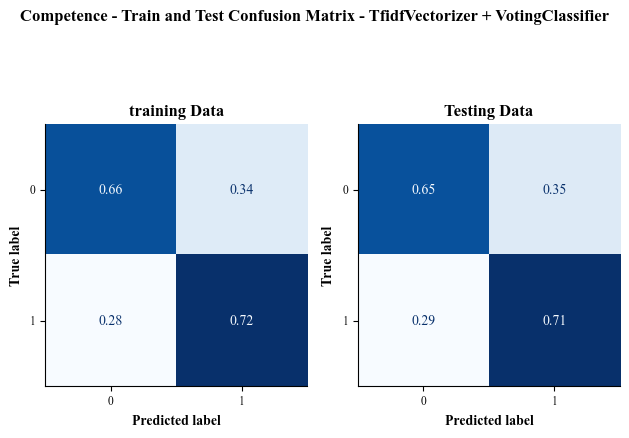

Train and Test Scores in K Folds Cross Validation:
K Folds plot at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/plots/Supervised Competence - Train and Test Scores in K Folds Cross Validation - TfidfVectorizer + VotingClassifier.eps
K Folds plot at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/plots/Supervised Competence - Train and Test Scores in K Folds Cross Validation - TfidfVectorizer + VotingClassifier.png
K Folds plot at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/plots/Supervised Competence - Train and Test Scores in K Folds Cross Validation - TfidfVectorizer + VotingClassifier.svg


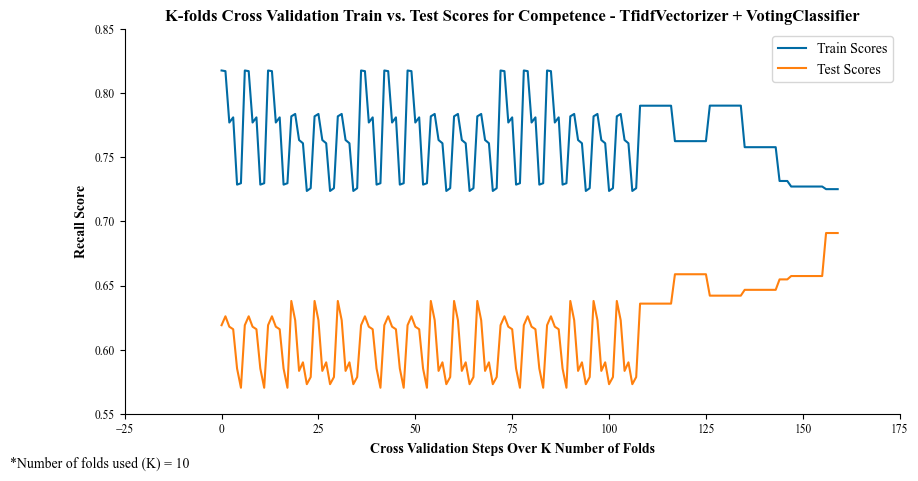

Saving fitted estimator
~~~~~~~~~~~~~~~~~~~~
Saving fitted estimator VotingClassifier at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Automating_Equity1/Automating_Equity1_Code/data/classification models/Supervised Results/
~~~~~~~~~~~~~~~~~~~~
Fitted estimator saved
~~~~~~~~~~~~~~~~~~~~
--------------------
Computing metrics using estimator.
--------------------
Cross Validating without scoring.
--------------------
Cross Validating with ['recall', 'accuracy', 'f1', 'roc_auc', 'explained_variance', 'matthews_corrcoef'] scoring.


  1%|          | 1/88 [04:42<6:50:03, 282.80s/it]

--------------------
Getting mean and std of cross validation scores.
--------------------
Saving cross validation scores to dataframe.
--------------------
Computing metrics using y_pred.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/homebrew/Caskroom/mambaforge/base/envs/Automating_Equity1/lib/python3.10/site-packages/IPyt │
│ hon/core/magics/execution.py:1325 in time                                                        │
│                                                                                                  │
│   1322 │   │   else:                                                                             │
│   1323 │   │   │   st = clock2()                                                                 │
│   1324 │   │   │   try:                                                                          │
│ ❱ 1325 │   │   │   │   exec(code, glob, local_ns)                                                │
│   1326 │   │   │   │   out=None                                                                  │
│   1327 │   │   │   │   # multi-line %%time case                                                  │
│   1328 │   │   │   │   if expr_val is not None:                                                  │
│ in <module>:172                                                                                  │
│                                                                                                  │
│ in evaluation:16                                                                                 │
│                                                                                                  │
│   13 │   │   f1, mcc, fm, kappa, gmean, report, cm, cm_normalized,                               │
│   14 │   │   average_precision, roc_auc, auc, fpr, tpr, threshold,                               │
│   15 │   │   loss, precision_pr, recall_pr, threshold_pr,                                        │
│ ❱ 16 │   ) = compute_metrics_all(                                                                │
│   17 │   │   estimator, X, y_labels, y_pred, y_pred_prob,                                        │
│   18 │   │   col, vectorizer_name, classifier_name                                               │
│   19 │   )                                                                                       │
│                                                                                                  │
│ in compute_metrics_all:34                                                                        │
│                                                                                                  │
│   31 │   │   )                                                                                   │
│   32 │   # Using y_test_pred                                                                     │
│   33 │   if with_y_pred:                                                                         │
│ ❱ 34 │   │   (                                                                                   │
│   35 │   │   │   explained_variance, accuracy, balanced_accuracy, precision,                     │
│   36 │   │   │   recall, f1, mcc, fm, r2, kappa, gmean, report, imblearn_report, cm, cm_norma    │
│   37 │   │   ) = compute_metrics_with_y_pred(                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: too many values to unpack (expected 15)

In [26]:
%%time
print('#'*40)
print('Starting!')
print('#'*40)

method = 'Supervised'
analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'

# Get existing estimators
estimator_names_list = get_existing_files()
done_estimators = glob.glob(f'{done_xy_save_path}*')
done_files = [
    'df_train_data', 'df_test_data', 'df_val_data', 'df_cv_results', 'Grid Search', 'SearchCV'
]

# Identify cols, vectorizers and classifiers
for estimators_file in tqdm.tqdm(glob.glob(f'{results_save_path}{method} Estimator - *.pkl')):
    assert f'{method} Estimator - ' in estimators_file, f'Estimators file name {estimators_file} does not contain {method} Estimator - '
    estimate_file_name = estimators_file.split(f'{method} Estimator - ')[-1]

    # Skip fitted estimators
    fitted_estimators = [fitted_estimators_file.split(f'{method} Fitted Estimator - ')[-1] for fitted_estimators_file in tqdm.tqdm(glob.glob(f'{results_save_path}{method} Fitted Estimator - *.pkl'))]
    if estimate_file_name in fitted_estimators and skip_fitted_estimators is True:
        print(f'Estimator {estimate_file_name} already fitted! Skipping...')
        continue

    # Specify col, vectorizer and classifier
    col = estimate_file_name.split(' - ')[0]
    vectorizer_name = estimators_file.split(f'{col} - ')[-1].split(' + ')[0]
    classifier_name = estimators_file.split(f'{vectorizer_name} + ')[-1].split(' (Save_protocol=')[0]
    protocol = int(estimators_file.split(f'{vectorizer_name} + ')[-1].split(' (Save_protocol=')[-1].split(').pkl')[0])

    # Load Table DF
    df_metrics = make_df_metrics(
        vectorizers_pipe=vectorizers_pipe, classifiers_pipe=classifiers_pipe, transformers_pipe=transformers_pipe,
        metrics_list=metrics_dict,
        col=col, vectorizer_name=vectorizer_name, classifier_name=classifier_name, protocol=protocol
    )

    print('~'*20)
    print(f'Loading data for {col} - {vectorizer_name} + {classifier_name}')
    print('~'*20)
    # Load X, y, search_cv, estimator
    (
        grid_search, searchcv,
        X_train, y_train, y_train_pred,
        X_test, y_test, y_test_pred, y_test_pred_prob,
        X_val, y_val, y_val_pred, y_val_pred_prob,
        df_feature_importances, df_cv_results, estimator,
    ) = load_Xy_search_cv_estimator(
        col, vectorizer_name, classifier_name, protocol
    )

    if searchcv.__class__.__name__ != 'CalibratedClassifierCV':
        print('-'*20)
        print(f'{"="*30} EVALUATING DATASET OF LENGTH {len(X_train)+len(X_test)+len(X_val)} ON {col.upper()} {"="*30}')
        print('='*20)
        print(
            f'GridSearch - Best mean train score: M = {float(best_mean_train_score:=searchcv.cv_results_["mean_train_score"][best_index:=searchcv.best_index_]):.2f}, SD = {int(best_std_train_score:=searchcv.cv_results_["std_train_score"][best_index]):.2f}\n'
        )
        print(
            f'GridSearch - Best mean test score: M = {float(best_mean_test_score:=searchcv.cv_results_["mean_test_score"][best_index]):.2f}, SD = {int(best_std_test_score:=searchcv.cv_results_["std_test_score"][best_index]):.2f}\n'
        )
        print(
            f'Best train score for {scoring}: {float(best_train_score:=searchcv.best_score_):.2f}\n'
        )
        print(
            f'Best test score for {scoring}: {float(best_test_score:=searchcv.score(X_test, y_test)):.2f}\n'
        )
        print(
            f'Number of splits: {int(n_splits:=searchcv.n_splits_)}\n'
        )
        print(
            f'Best estimator:\n{searchcv.best_estimator_}\n'
        )
        print(
            f'Best estimator and parameters:\n{searchcv.best_params_}\n'
        )
        print(
            f'Testing Classification Report:\n{(train_report:=metrics.classification_report(y_test, y_test_pred, labels=np.unique(y_test_pred), zero_division=0))}\n'
        )
        # Examine predictions
        examine_predictions(
            X_test, y_test, y_test_pred, col
        )
        print('='*20)
        # Train and Test Confusion Matrix
        print('='*20)
        print('Train and Test Confusion Matrix:\n')
        close_plots()
        fig, axs = plt.subplots(1, 2)
        fig.suptitle(f'{col} - Train and Test Confusion Matrix - {vectorizer_name} + {classifier_name}')
        for ax in axs:
            ax.set_aspect('equal')
        train_cm = metrics.ConfusionMatrixDisplay.from_estimator(
            estimator, X_train, y_train, normalize='true', ax=axs[0], cmap=plt.cm.Blues, colorbar=False
        )
        train_cm.ax_.set_title('training Data')
        test_cm = metrics.ConfusionMatrixDisplay.from_estimator(
            estimator, X_test, y_test, normalize='true', ax=axs[1], cmap=plt.cm.Blues, colorbar=False
        )
        test_cm.ax_.set_title('Testing Data')
        plt.tight_layout()
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} {col} - Train and Test Confusion Matrix - {vectorizer_name} + {classifier_name}.{image_save_format}'
            print(f'Train and Test Confusion Matrix plot at {save_path}')
            fig.savefig(
                save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
            )
        show_and_close_plots()
        print('='*20)
        # Train and Test ROC Curve
        print('='*20)
        print('Train and Test Scores in K Folds Cross Validation:')
        close_plots()
        fig = plt.figure(figsize=(10, 5))
        plt.title(f'K-folds Cross Validation Train vs. Test Scores for {col} - {vectorizer_name} + {classifier_name}')
        plt.plot(searchcv.cv_results_["mean_train_score"], label='Train Scores')
        plt.plot(searchcv.cv_results_["mean_test_score"], label='Test Scores')
        plt.legend(loc='best')
        plt.xlabel('Cross Validation Steps Over K Number of Folds')
        plt.ylabel('Recall Score')
        fig.text(0.1, 0.01, '*Number of folds used (K) = 10', ha='center', va='center', fontsize=10)
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} {col} - Train and Test Scores in K Folds Cross Validation - {vectorizer_name} + {classifier_name}.{image_save_format}'
            print(f'K Folds plot at {save_path}')
            fig.savefig(
                save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
            )
        show_and_close_plots()
        print('='*20)

        if evaluate_estimator_on_concat:
            # Fit estimator
            print('~'*20)
            print('Fitting best params to estimator')
            X = np.concatenate((X_train, X_val), axis=0)
            y_labels = np.concatenate((y_train, y_val), axis=0)
            estimator = estimator.set_params(**searchcv.best_params_)
            estimator.fit(X, y)

            # Normalize Xy for unusual classifiers after fitting
            (
                estimator, X, y_labels, X_test, y_test, searchcv, df_feature_importances
            ) = normalize_after_fitting(
                estimator, X, y_labels, X_test, y_test, grid_search, searchcv, vectorizer_name, classifier_name
            )

            # Set prediction probability attribute
            if hasattr(estimator, 'predict_proba'):
                searchcv_predict_attr = estimator.predict_proba
            elif hasattr(estimator, '_predict_proba_lr'):
                searchcv_predict_attr = estimator._predict_proba_lr

            # Get predictions and probabilities
            y_pred = estimator.predict(X_test)
            y_pred_prob = searchcv_predict_attr(X_test)[:, 1]
        else:
            X = X_test
            y_labels = y_test
            y_pred = y_test_pred
            y_pred_prob = y_test_pred_prob

        print('Saving fitted estimator')
        save_fitted_estimator(
            estimator, col, vectorizer_name, classifier_name, protocol,
        )
        print('Fitted estimator saved')
        print('~'*20)

        # Evaluate Model
        df_metrics, metrics_dict, df_cv_score_recall = evaluation(
            estimator, X, y_labels, y_pred, y_pred_prob,
            best_train_score, df_metrics,
            col, vectorizer_name, classifier_name, plot_enabled=True
        )

        # Confirmatory Regression
        prob_confirmatory_tests(y_pred, y_pred_prob)

        # Save Vectorizer, Selector, and Classifier
        save_table(df_metrics, col, vectorizer_name, classifier_name, protocol)
        print(df_metrics)

    # # Compare Estimators
    # print('='*20)
    # print(f'Comparing Estimators for {col}')
    # comparison_plots(get_completed_estimators(), X_test, y_test, col)
    # print('='*20)

print('#'*40)
print('DONE!')
print('#'*40)
